In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

In [2]:
data = pd.read_csv('marketing_campaign.csv', sep="\t")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [4]:
#remove NA
data = data.dropna()
len(data) #number of rows without NA

2216

In [5]:
#change the date of Dt_Customer to datetime format
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"])
dates = []
for i in data["Dt_Customer"]:
    i = i.date()
    dates.append(i) 

In [6]:
#assume the newest customer enrolled in day 1, how long had each customer been with us
#a new feature Consumer_Days
days = []
d1 = max(dates) #taking it to be the newest customer
for i in dates:
    delta = d1 - i
    days.append(delta)
data["Consumer_Days"] = days
data["Consumer_Days"] = pd.to_numeric(data["Consumer_Days"], errors="coerce")
data["Consumer_Days"]

0       83894400000000000
1       10800000000000000
2       40780800000000000
3        5616000000000000
4       27734400000000000
              ...        
2235    46742400000000000
2236     5270400000000000
2237    27216000000000000
2238    27302400000000000
2239    67564800000000000
Name: Consumer_Days, Length: 2216, dtype: int64

In [7]:
#check unique values in categorical variables Marital_Status and Education
print(data["Marital_Status"].value_counts())
print(data["Education"].value_counts())

Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
YOLO          2
Absurd        2
Name: Marital_Status, dtype: int64
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64


In [8]:
#Deriving living situation by marital status"Alone"
data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

In [9]:
#Segmenting education levels in three groups
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

In [10]:
#Age of customer today 
#since the min year of birth is 1893, assume this dataset is old and collected in 2000
data["Age"] = 2000-data["Year_Birth"]

In [11]:
#Total spendings on wines, fruits, meat, fish, sweet, gold products
data["Spent"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

In [12]:
#Number of Children at home
data["Children"]=data["Kidhome"]+data["Teenhome"]

In [13]:
#Feature for total members in the householde
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]

In [14]:
#rename features
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

In [15]:
#Dropping some of the redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

In [16]:
data.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Consumer_Days,Age,Spent,Children,Family_Size
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.073105,0.064079,0.013538,0.009477,0.150271,4.423735e+16,31.179603,607.075361,0.947202,2.592509
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.260367,0.244950,0.115588,0.096907,0.357417,2.008532e+16,11.985554,602.900476,0.749062,0.905722
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,4.000000,5.000000,0.000000,1.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.937600e+16,23.000000,69.000000,0.000000,2.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,4.432320e+16,30.000000,396.500000,1.000000,3.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,5.927040e+16,41.000000,1048.000000,1.000000,3.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,9.184320e+16,107.000000,2525.000000,3.000000,5.000000


In [17]:
#drop outliers on Age and Income 
data = data[(data["Age"]<90)]
data = data[(data["Income"]<600000)]
len(data)

2212

In [18]:
#Get list of categorical variables
s = (data.dtypes == 'object')
object_cols = [list(s[s].index)[1]]

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Living_With']


In [19]:
#Label Encoding the categorical variables: Education, Living_with.
LE=LabelEncoder()
for i in object_cols:
    data[i]=data[[i]].apply(LE.fit_transform)

In [20]:
# Replacing eduaction with integer values
data['Education'] = data['Education'].replace({'Undergraduate':0, 'Graduate':1, 'Postgraduate':2})

In [21]:
#promotion will not be used in the data analysis temporarily. 
#For now creat a copy of dataset and drop all promotion-related features

In [22]:
#Creating a copy of data
ds = data.copy()
# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)
#Scaling
scaler = StandardScaler()
scaler.fit(ds)
data_scaled = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")

All features are now scaled


In [23]:
data_scaled.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Consumer_Days,Living_With,Age,Spent,Children,Family_Size
0,-0.411675,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,...,1.426865,2.503607,-0.555814,0.692181,1.973583,-1.349603,1.018352,1.676245,-1.264598,-1.758359
1,-0.411675,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,...,-1.126420,-0.571340,-1.171160,-0.132545,-1.665144,-1.349603,1.274785,-0.963297,1.404572,0.449070
2,-0.411675,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,...,1.426865,-0.229679,1.290224,-0.544908,-0.172664,0.740959,0.334530,0.280110,-1.264598,-0.654644
3,-0.411675,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,...,-0.761665,-0.913000,-0.555814,0.279818,-1.923210,0.740959,-1.289547,-0.920135,0.069987,0.449070
4,1.123949,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,...,0.332600,0.111982,0.059532,-0.132545,-0.822130,0.740959,-1.033114,-0.307562,0.069987,0.449070


In [24]:
data_scaled.columns

Index(['Education', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'Wines',
       'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'Consumer_Days', 'Living_With', 'Age', 'Spent',
       'Children', 'Family_Size'],
      dtype='object')

In [25]:
# Data Subsets with best Silhouette Score
data_scaled2 = data_scaled[['Education', 'Wines','Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'Family_Size', 'Spent']]
data_scaled3 = data_scaled[['Spent','Education','Income','NumDealsPurchases', 'Family_Size', 'NumWebVisitsMonth']]
data_scaled3_2 = ds[['Spent','Education','Income','NumDealsPurchases', 'Family_Size', 'NumWebVisitsMonth', 'NumStorePurchases', 'Wines','Fruits', 'Meat', 'Fish', 'Sweets', 'Gold']]
data_scaled4 = data_scaled[['Spent','Education']]


In [26]:
#reduce dimention with PCA for noise reduction
pca = PCA(n_components=2)
pca.fit(data_scaled3)
data_input = pd.DataFrame(pca.transform(data_scaled3), columns=(["col1","col2"]))

pca2 = PCA(n_components=3)
pca2.fit(data_scaled3)
data_input2 = pd.DataFrame(pca2.transform(data_scaled3), columns=(["col1","col2","col3"]))



When doing the modeling, can try change the PCA dimension to 3: PCA(n_components=3) and see how it will influence the model performance


# Modeling using Affinity Propagation
- Inductive learning: Observation -> Pattern recognition -> Conclusion
- Don't have to choose number of clusters or initial set of points
- Rather it takes in measures of similarities between pairs of datapoints, simultaneously considering all datapoints as possible exemplars/cluster-centers

In [27]:
data_input.head(2)

,col1,col2
0,-1.220319,-0.155063
1,0.730875,-0.467757


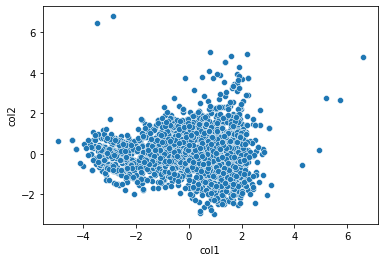

In [28]:
sns.scatterplot(data=data_input, x='col1', y='col2');

In [29]:
# af_model = AffinityPropagation(damping = 0.8, preference=-3000, random_state=42, verbose=True) // For all columns 0.5126403055689395 s_score 
# af_model = AffinityPropagation(damping = 0.9, preference=-100, random_state=42, verbose=True) // subset3 0.6327132059351224
# af_model = AffinityPropagation(damping = 0.9, preference=-200, random_state=42, verbose=True) // subset2 0.5147080156663487
# af_model = AffinityPropagation(damping = 0.9, preference=-50, random_state=42, verbose=True) // Subset4 0.6778714609151942
# af_model = AffinityPropagation(damping = 0.9, preference=-50, random_state=42, verbose=True)
# clustering = af_model.fit(data_input)


Converged after 56 iterations.
Number of clusters:  3
Silhouette Score:  0.413125865197588


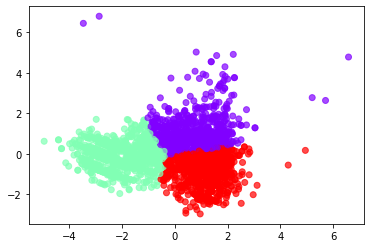

In [30]:
af_model = AffinityPropagation(damping = 0.9, preference=-1000, random_state=42, verbose=True)
clustering = af_model.fit(data_input)
print("Number of clusters: ", len(set(clustering.labels_)))
print("Silhouette Score: ", metrics.silhouette_score(data_input, clustering.labels_))
plt.scatter(data_input.iloc[:,0], data_input.iloc[:,1], c=clustering.labels_, cmap='rainbow', alpha=0.7);

# Using PCA dimension = 3

In [31]:
data_input2.head(5)

,col1,col2,col3
0,-1.220319,-0.155063,0.904712
1,0.730875,-0.467757,0.000624
2,-1.279900,-0.596242,0.186781
3,1.397937,-0.715897,-0.119123
4,0.353169,1.659819,-0.296444


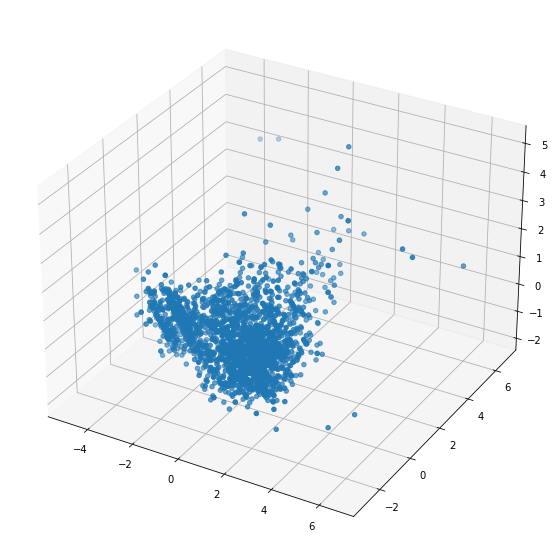

In [32]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
fg = ax.scatter3D(data_input2.iloc[:,0], data_input2.iloc[:,1], data_input2.iloc[:,2]);

Converged after 83 iterations.
Number of clusters:  3
Silhouette Score:  0.3470648419428743


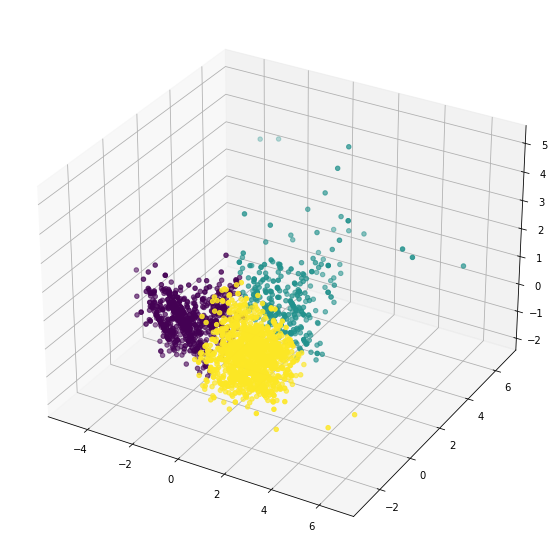

In [33]:
af_model2 = AffinityPropagation(damping = 0.8, preference=-1000, random_state=42, verbose=True)
clustering2 = af_model2.fit(data_input2)
print("Number of clusters: ", len(set(clustering2.labels_)))
print("Silhouette Score: ", metrics.silhouette_score(data_input2, clustering2.labels_))
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
fg = ax.scatter3D(data_input2.iloc[:,0], data_input2.iloc[:,1], data_input2.iloc[:,2], c=clustering2.labels_);

# Checking what the clusters represent

In [34]:
cluster_df = data_scaled3_2.copy()
cluster_df['clusterLabels'] = clustering.labels_

In [35]:
cluster_df = cluster_df.sort_values('clusterLabels', axis=0)

In [36]:
cluster_df.head(4)

,Spent,Education,Income,NumDealsPurchases,Family_Size,NumWebVisitsMonth,NumStorePurchases,Wines,Fruits,Meat,Fish,Sweets,Gold,clusterLabels
2239,172,2,52869.0,3,4,7,4,84,3,61,2,1,21,0
619,326,2,30522.0,5,3,2,9,179,8,83,19,11,26,0
620,404,2,54456.0,3,3,6,7,352,0,27,10,0,15,0
1558,102,1,27215.0,4,4,6,4,30,5,22,8,9,28,0


## Visualizations

Using the most insightfull features

32607.5

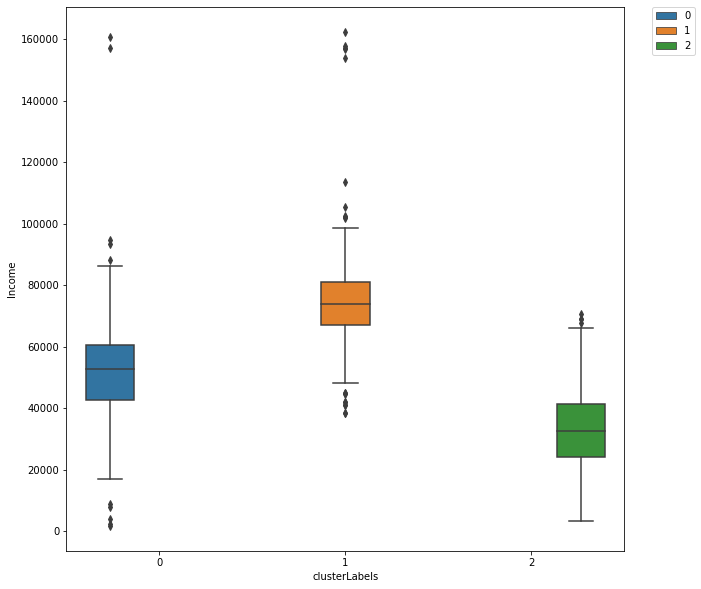

In [37]:
plt.figure(figsize=(10,10))
sns.boxplot(
    data=cluster_df, x='clusterLabels', y='Income', hue="clusterLabels"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
np.median(cluster_df[cluster_df['clusterLabels']==2]['Income'])

62.5

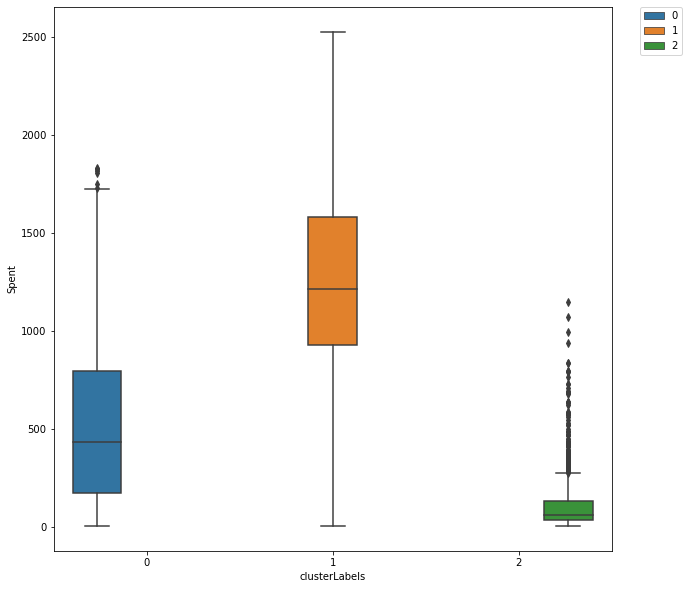

In [38]:
plt.figure(figsize=(10,10))
sns.boxplot(
    data=cluster_df, x='clusterLabels', y='Spent', hue="clusterLabels"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
np.median(cluster_df[cluster_df['clusterLabels']==2]['Spent'])

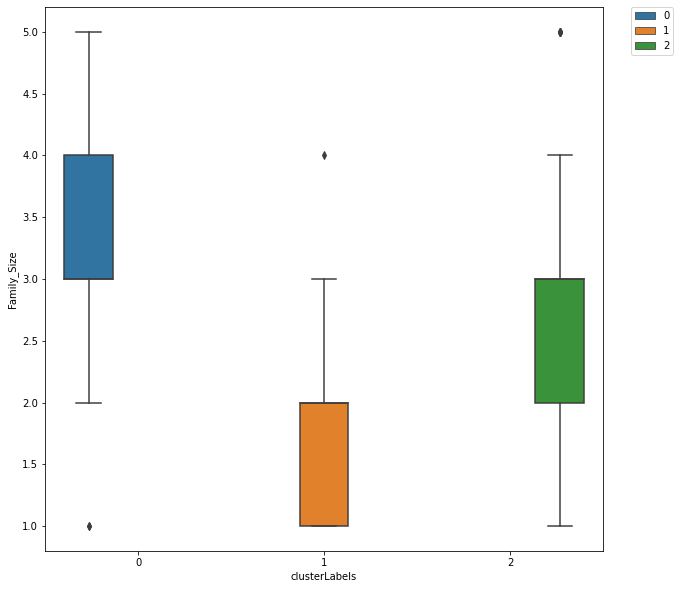

In [39]:
plt.figure(figsize=(10,10))
sns.boxplot(
    data=cluster_df, x='clusterLabels', y='Family_Size', hue="clusterLabels"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
# sns.histplot(cluster_df[cluster_df['clusterLabels']==1]['Family_Size'])

2.0

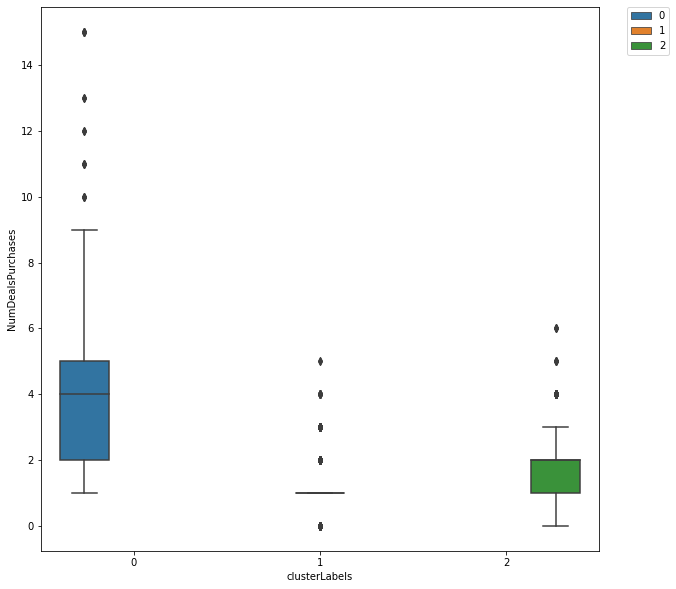

In [40]:
plt.figure(figsize=(10,10))
sns.boxplot(data=cluster_df, x='clusterLabels', y='NumDealsPurchases', hue="clusterLabels")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
np.median(cluster_df[cluster_df['clusterLabels']==2]['NumDealsPurchases'])

7.0

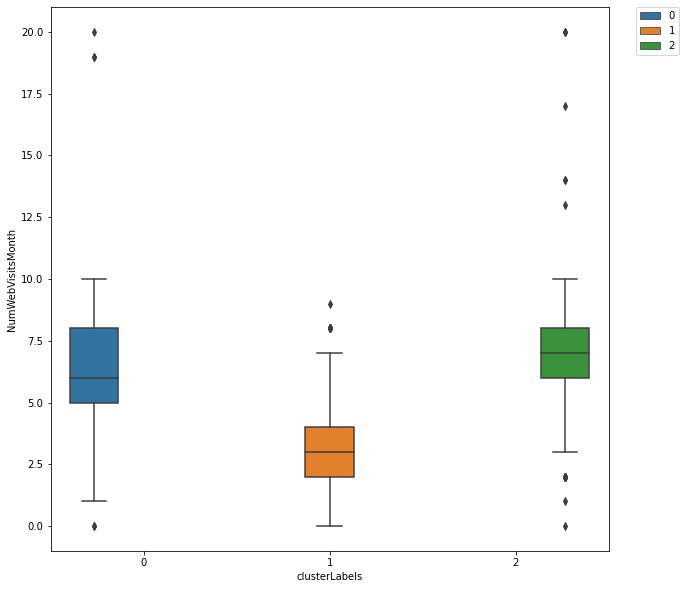

In [41]:
plt.figure(figsize=(10,10))
sns.boxplot(data=cluster_df, x='clusterLabels', y='NumWebVisitsMonth', hue="clusterLabels")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
np.median(cluster_df[cluster_df['clusterLabels']==2]['NumWebVisitsMonth'])

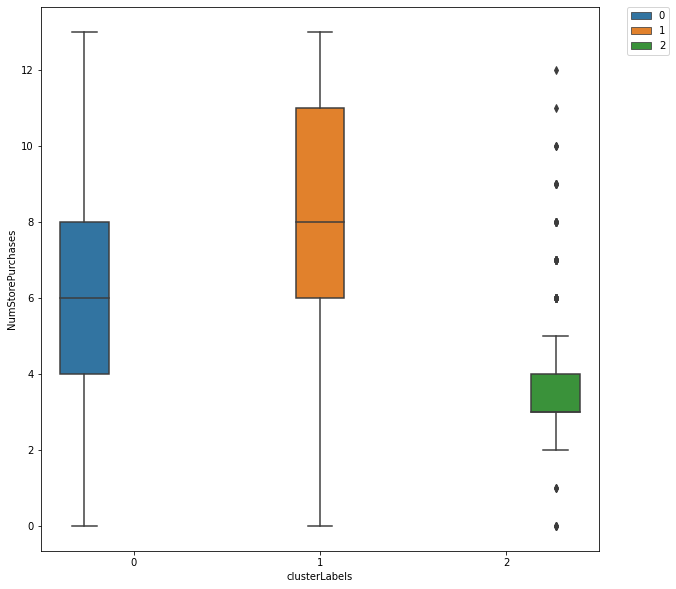

In [42]:
plt.figure(figsize=(10,10))
sns.boxplot(data=cluster_df, x='clusterLabels', y='NumStorePurchases', hue="clusterLabels")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

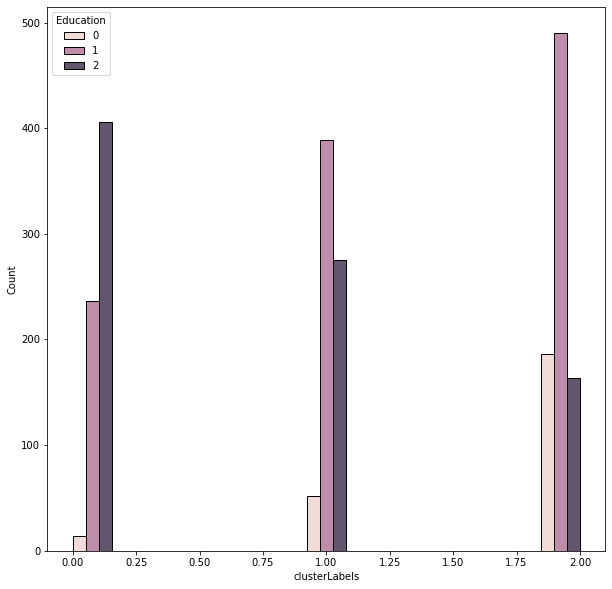

In [43]:
plt.figure(figsize=(10,10))
sns.histplot(
    data=cluster_df, x='clusterLabels', hue="Education", multiple="dodge", stat='count'
);


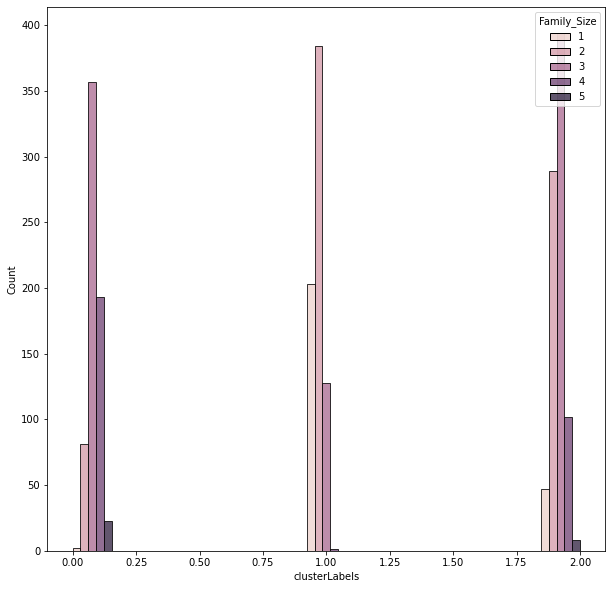

In [44]:
plt.figure(figsize=(10,10))
sns.histplot(
    data=cluster_df, x='clusterLabels', hue="Family_Size", multiple="dodge", stat='count'
);



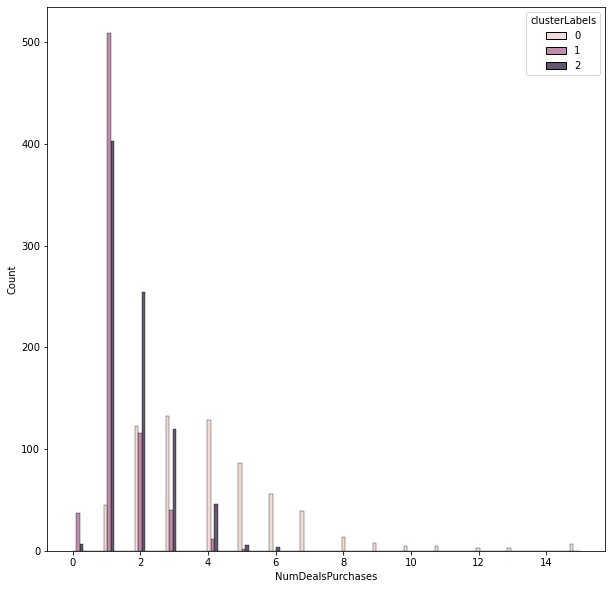

In [45]:
plt.figure(figsize=(10,10))
sns.histplot(
    data=cluster_df, x='NumDealsPurchases', hue="clusterLabels", multiple="dodge", stat='count'
);

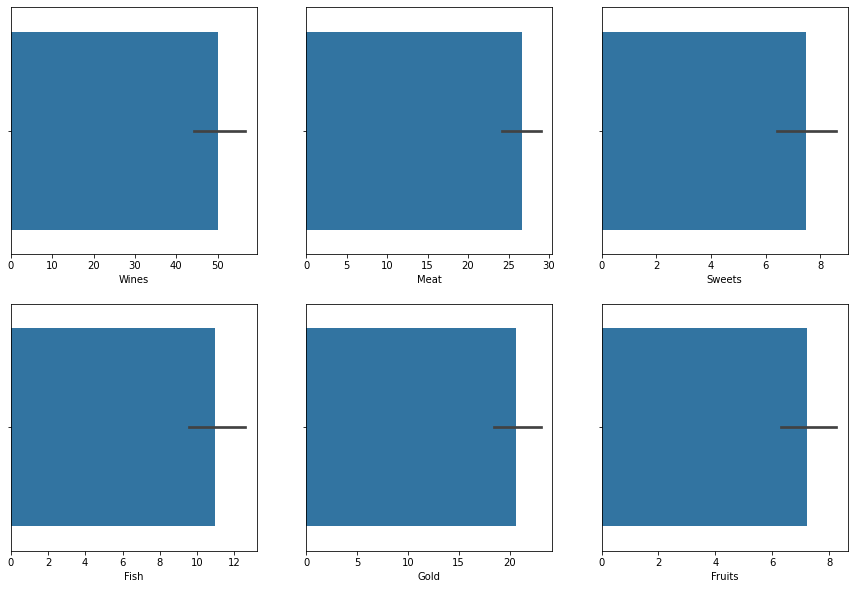

In [46]:
mydf = cluster_df[cluster_df['clusterLabels']==2]
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
sns.barplot(ax=axes[0][0], data=mydf, x='Wines');
sns.barplot(ax=axes[0][1], data=mydf, x='Meat');
sns.barplot(ax=axes[0][2], data=mydf, x='Sweets');
sns.barplot(ax=axes[1][0], data=mydf, x='Fish');
sns.barplot(ax=axes[1][1], data=mydf, x='Gold');
sns.barplot(ax=axes[1][2], data=mydf, x='Fruits');

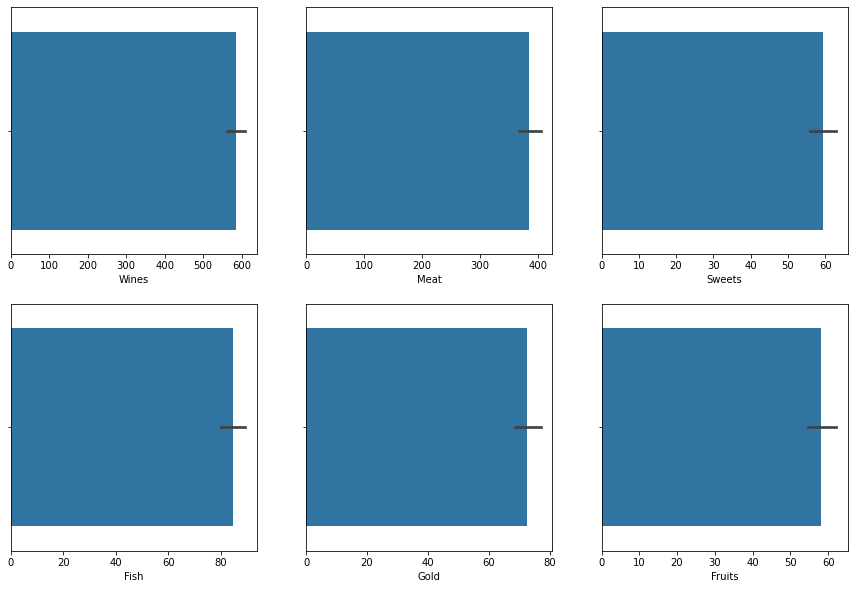

In [47]:
mydf = cluster_df[cluster_df['clusterLabels']==1]
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
sns.barplot(ax=axes[0][0], data=mydf, x='Wines');
sns.barplot(ax=axes[0][1], data=mydf, x='Meat');
sns.barplot(ax=axes[0][2], data=mydf, x='Sweets');
sns.barplot(ax=axes[1][0], data=mydf, x='Fish');
sns.barplot(ax=axes[1][1], data=mydf, x='Gold');
sns.barplot(ax=axes[1][2], data=mydf, x='Fruits');

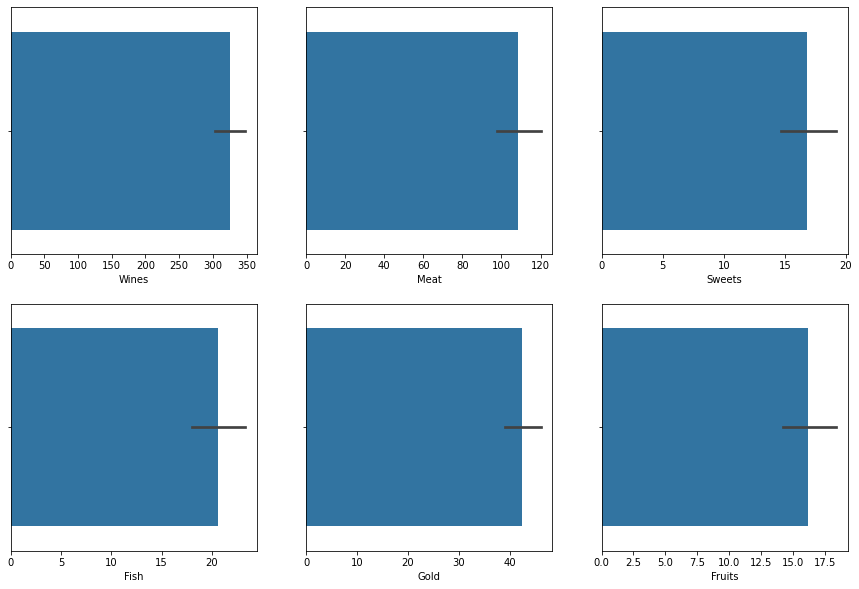

In [48]:
mydf = cluster_df[cluster_df['clusterLabels']==0]
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
sns.barplot(ax=axes[0][0], data=mydf, x='Wines');
sns.barplot(ax=axes[0][1], data=mydf, x='Meat');
sns.barplot(ax=axes[0][2], data=mydf, x='Sweets');
sns.barplot(ax=axes[1][0], data=mydf, x='Fish');
sns.barplot(ax=axes[1][1], data=mydf, x='Gold');
sns.barplot(ax=axes[1][2], data=mydf, x='Fruits');

Using all Features

In [49]:
# plt.figure(figsize=(10,10))
# sns.boxplot(
#     data=cluster_df, x='clusterLabels', y='Wines', hue="clusterLabels"
# )
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [50]:
# plt.figure(figsize=(10,10))
# sns.boxplot(
#     data=cluster_df, x='clusterLabels', y='NumStorePurchases', hue="clusterLabels"
# )
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [51]:
# plt.figure(figsize=(10,10))
# sns.boxplot(
#     data=cluster_df, x='clusterLabels', y='Income', hue="clusterLabels"
# )
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [52]:
# plt.figure(figsize=(10,10))
# sns.boxplot(
#     data=cluster_df, x='clusterLabels', y='Spent', hue="clusterLabels"
# )
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

Using Features that give off the highest Silhouette Score

In [53]:
# plt.figure(figsize=(10,10))
# sns.boxplot(data=cluster_df, x='clusterLabels', y='Education');

In [54]:
# plt.figure(figsize=(10,10))
# sns.histplot(data=cluster_df, x='Education', hue="clusterLabels", multiple="dodge", stat='count');

In [55]:
# plt.figure(figsize=(10,10))
# sns.boxplot(
#     data=cluster_df, x='Education', y='Spent', hue="clusterLabels"
# )
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);